Importar librerias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

Definir parámetros

In [3]:
# Parámetros
window_sizes = [1]  # Ventanas en horas  6,12, 24
rows, cols, channels = 95, 68, 1 # Reducción en la resolución de las imágenes dimensión original = 190, 136, 1
n_iteraciones = 1

Cargar y escalar datos

In [4]:
# Cargar datos
data_path = '/kaggle/input/data-horas/Datos_horas.xlsx'
# Cargar datos
data = pd.read_excel(data_path)
numeric_cols = data.select_dtypes(include=[np.number]).columns
data[numeric_cols] = data[numeric_cols].apply(lambda x: x.fillna(x.mean()), axis=0)

# Aplicar escaladores
scalers = {
    'MinMaxScaler': MinMaxScaler(),
}

scaled_data = {}
for scaler_name, scaler in scalers.items():
    scaled_data[scaler_name] = pd.DataFrame(scaler.fit_transform(data[numeric_cols]), columns=numeric_cols)
    if 'Biomasa' in data.columns:
        scaled_data[scaler_name]['Biomasa'] = data['Biomasa']

Cargar imágenes

In [5]:
# Cargar imágenes por horas
image_dir = '/kaggle/input/fotos-horas/Datos_horas'

all_images = []

for day in range(1, 31):
    day_folder = os.path.join(image_dir, f'dia {day}')
    if not os.path.exists(day_folder):
        continue

    images_day = []
    for img_name in sorted(os.listdir(day_folder)):
        img_path = os.path.join(day_folder, img_name)
        img = load_img(img_path, color_mode='grayscale', target_size=(rows, cols))
        img_array = img_to_array(img) / 255.0
        images_day.append(img_array)

    all_images.extend(images_day)

all_images = np.array(all_images)
print("Total de imágenes cargadas:", all_images.shape)

Total de imágenes cargadas: (720, 95, 68, 1)


Definir función de entrenamiento del modelo

In [6]:
# Función de entrenamiento
def train_model(data, images, window_hours, n_iteraciones):
    metrics_summary = {'R2': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'Spearman': [], 'MAPE': []}

    img_sequences, target_sequences = [], []
    for i in range(len(images) - window_hours + 1):
        # Verificar si hay suficientes datos en 'data' para la ventana actual
        if i + window_hours > len(data):
            print(f"Insuficientes datos para ventana de {window_hours} horas en índice {i}.")
            break
        img_sequences.append(images[i:i + window_hours])
        target_sequences.append(data['Biomasa'].iloc[i + window_hours - 1])

    if not img_sequences:
        print(f"Ventana de {window_hours} horas insuficiente para los datos disponibles.")
        return None, None, None, None, None

    # Convertir a numpy array y ajustar forma para input del modelo
    img_sequences = np.array(img_sequences).reshape((-1, window_hours, rows, cols, channels))
    target_sequences = np.array(target_sequences)

    # División 70-30
    img_train, img_test, y_train, y_test = train_test_split(
        img_sequences, target_sequences, test_size=0.3, shuffle=True)

    # Definir el modelo CNN-LSTM
    inp = Input(shape=(window_hours, rows, cols, channels))
    x = ConvLSTM2D(32, (3, 3), padding="same", activation="relu", return_sequences=True)(inp)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(64, (3, 3), padding="same", activation="relu", return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = ConvLSTM2D(128, (3, 3), padding="same", activation="relu", return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dense(128, activation='tanh')(x)
    x = Dense(64, activation='tanh')(x)
    output = Dense(1, activation='linear')(x) #linear

    model = Model(inputs=inp, outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae", "mse"])

    # Inicializar la variable para las métricas
    metrics_summary = {'R2': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'Spearman': [], 'MAPE': []}

    # Entrenamiento con Early Stopping (sin validación explícita)
    early_stop = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

    for iteration in range(n_iteraciones):
        print(f"\nIteración {iteration + 1} de {n_iteraciones}")

        # Entrenamiento del modelo
        history = model.fit(img_train, y_train, epochs=200, batch_size=16, callbacks=[early_stop])

        # Predicción y cálculo de métricas
        y_pred = model.predict(img_test).flatten()
        metrics_summary['R2'].append(r2_score(y_test, y_pred))
        metrics_summary['MSE'].append(mean_squared_error(y_test, y_pred))
        metrics_summary['RMSE'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        metrics_summary['MAE'].append(mean_absolute_error(y_test, y_pred))
        metrics_summary['Spearman'].append(spearmanr(y_test, y_pred).correlation)
        metrics_summary['MAPE'].append(mean_absolute_percentage_error(y_test, y_pred))

    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics_summary.items()}

    return model, history, avg_metrics, y_test, y_pred


# Número de iteraciones que deseas realizar
n_iteraciones = 1  # Ajusta este valor según sea necesario

# Ejecución y Exportación de Resultados 70-30
results = {}

for scaler_name, data_scaled in scaled_data.items():
    results[scaler_name] = {}

    for window_hours in window_sizes:
        print(f"\nEntrenando con {scaler_name} y ventana de {window_hours} horas...")

        # Llamada a la función de entrenamiento con el parámetro n_iteraciones
        output = train_model(data_scaled, all_images, window_hours, n_iteraciones)

        if output[0] is None:
            continue  # Saltar si no hay suficientes datos

        model, history, metrics, y_test, y_pred = output

        # Guardar los resultados en el diccionario
        results[scaler_name][window_hours] = {
            'model': model,
            'history': history.history,
            'metrics': metrics,
            'y_test': y_test,
            'y_pred': y_pred
        }

        # Imprimir las métricas para cada combinación de escalador y ventana
        print(f"Resultados para {scaler_name} con ventana de {window_hours} horas:")
        print(f"R2: {metrics['R2']}")
        print(f"MSE: {metrics['MSE']}")
        print(f"RMSE: {metrics['RMSE']}")
        print(f"MAE: {metrics['MAE']}")
        print(f"Spearman: {metrics['Spearman']}")
        print(f"MAPE: {metrics['MAPE']}")

        # Opcional: también puedes imprimir una muestra de las predicciones vs. los valores reales
        print("\nEjemplo de predicciones vs. reales:")
        for i in range(5):  # Imprimir solo los primeros 5 ejemplos
            print(f"Real: {y_test[i]}, Predicción: {y_pred[i]}")


Entrenando con MinMaxScaler y ventana de 1 horas...

Iteración 1 de 1
Epoch 1/200


I0000 00:00:1732767796.154921     100 service.cc:145] XLA service 0x5d0d2e445760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732767796.154976     100 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732767796.154980     100 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732767807.170736     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - loss: 9.6583 - mae: 2.6752 - mse: 9.6583

I0000 00:00:1732767819.675096     100 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion_9', 1000 bytes spill stores, 1000 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion_8', 776 bytes spill stores, 776 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion_7', 920 bytes spill stores, 920 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion_6', 776 bytes spill stores, 776 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_select_fusion_5', 920 bytes spill stores, 920 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_17', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled 

32/32 ━━━━━━━━━━━━━━━━━━━━ 31s 439ms/step - loss: 9.5716 - mae: 2.6592 - mse: 9.5716
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 1.7417 - mae: 1.0168 - mse: 1.7417
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.4556 - mae: 0.4724 - mse: 0.4556
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - loss: 0.0949 - mae: 0.2435 - mse: 0.0949
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - loss: 0.0690 - mae: 0.2018 - mse: 0.0690
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0692 - mae: 0.2011 - mse: 0.0692
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 161ms/step - loss: 0.0684 - mae: 0.1967 - mse: 0.0684
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - loss: 0.0661 - mae: 0.1949 - mse: 0.0661
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.0653 - mae: 0.2004 - mse: 0.0653
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.0539 - mae: 0.1752 - mse: 0.0539
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/s

In [7]:
# Visualización de gráficos
for scaler_name, scaler_results in results.items():
    for window_days, result in scaler_results.items():
        y_val = result['y_test']  # Valores reales
        y_pred = result['y_pred']  # Valores predichos
        history = result['history']  # Historial del modelo (diccionario de entrenamiento)


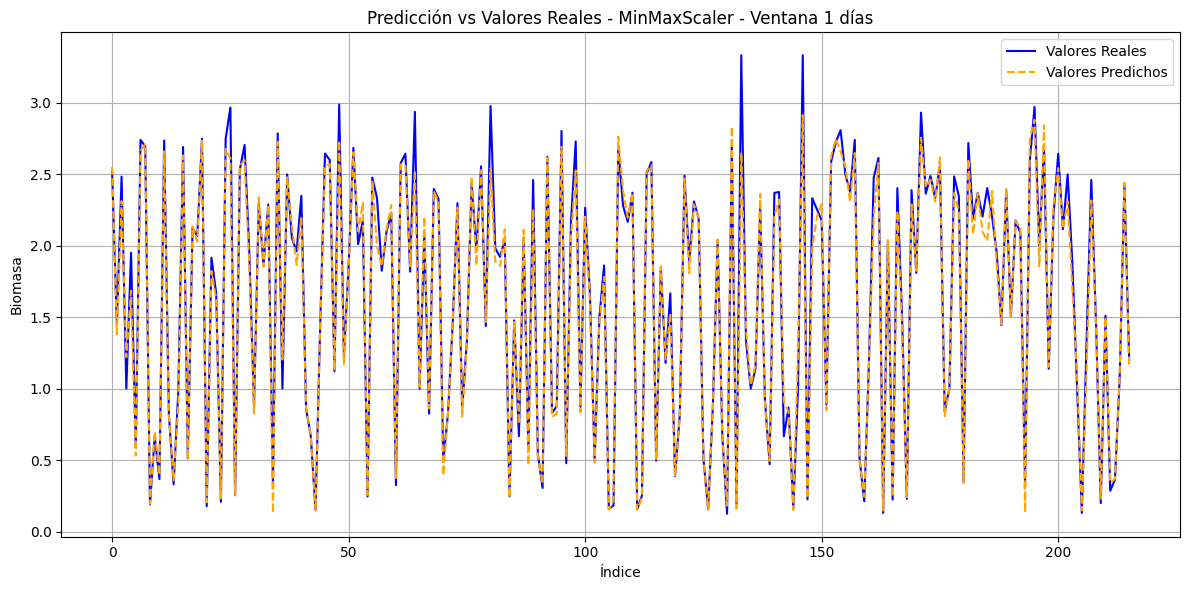

In [16]:
        # 1. Serie Temporal de Predicción vs Valores Reales
        plt.figure(figsize=(12, 6))
        plt.plot(y_val, label='Valores Reales', color='blue')
        plt.plot(y_pred, label='Valores Predichos', color='orange', linestyle='--')
        plt.title(f'Predicción vs Valores Reales - {scaler_name} - Ventana {window_days} días')
        plt.xlabel('Índice')
        plt.ylabel('Biomasa')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

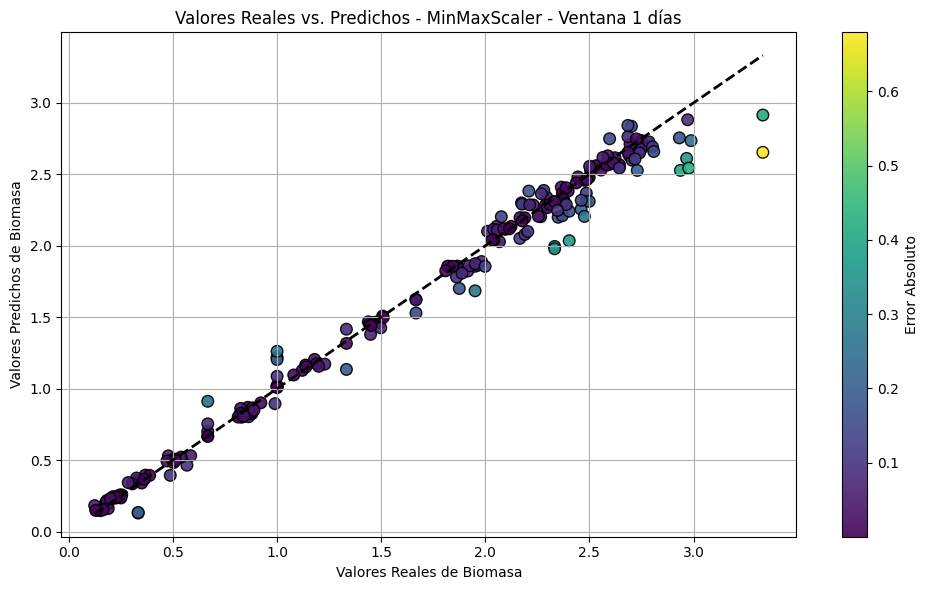

In [9]:
        # 2. Gráfico de Dispersión de Predicción vs Real
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            y_val, y_pred, c=np.abs(y_val - y_pred), cmap='viridis', s=70, alpha=0.9, edgecolor='black'
        )
        plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
        plt.title(f'Valores Reales vs. Predichos - {scaler_name} - Ventana {window_days} días')
        plt.xlabel('Valores Reales de Biomasa')
        plt.ylabel('Valores Predichos de Biomasa')
        cbar = plt.colorbar(scatter)
        cbar.set_label('Error Absoluto')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

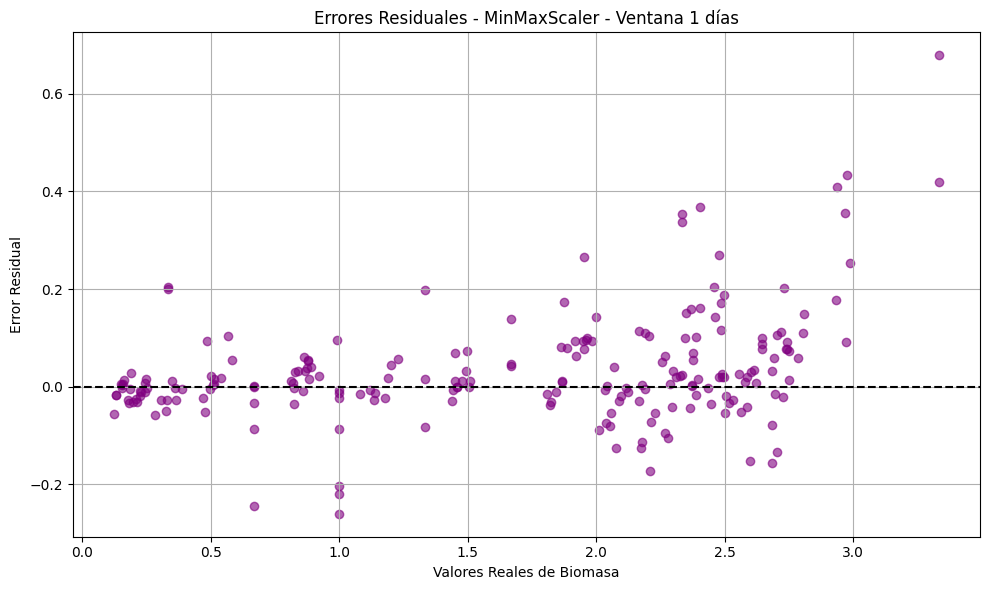

In [10]:
        # 3. Gráfico de Error Residual
        residuals = y_val - y_pred
        plt.figure(figsize=(10, 6))
        plt.scatter(y_val, residuals, alpha=0.6, color="purple")
        plt.axhline(0, linestyle='--', color='black')
        plt.title(f'Errores Residuales - {scaler_name} - Ventana {window_days} días')
        plt.xlabel('Valores Reales de Biomasa')
        plt.ylabel('Error Residual')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

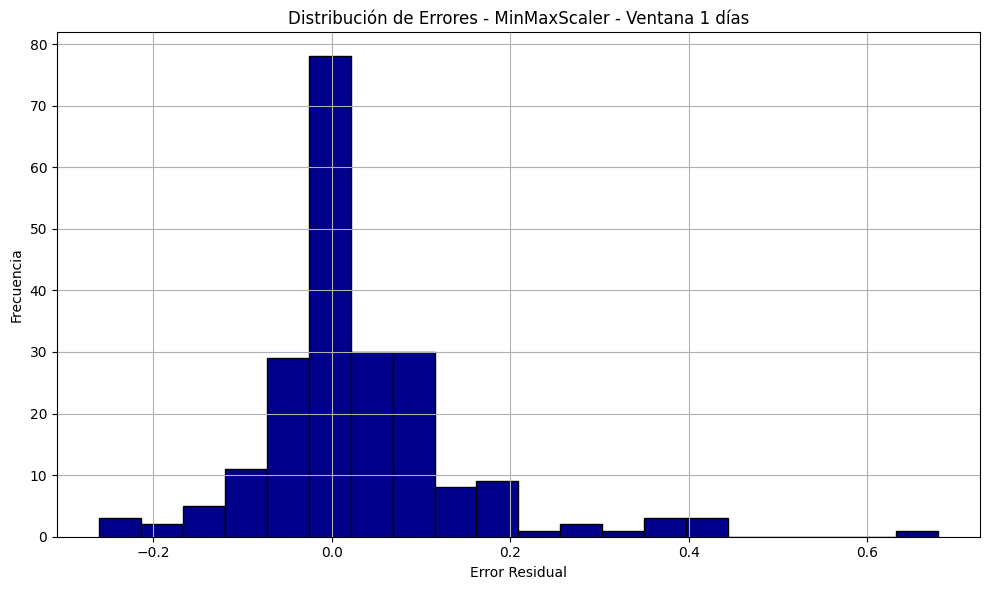

In [15]:
        # 4. Histograma de Errores
        plt.figure(figsize=(10, 6))
        plt.hist(residuals, bins=20, color="darkblue", edgecolor='black')
        plt.title(f'Distribución de Errores - {scaler_name} - Ventana {window_days} días')
        plt.xlabel('Error Residual')
        plt.ylabel('Frecuencia')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

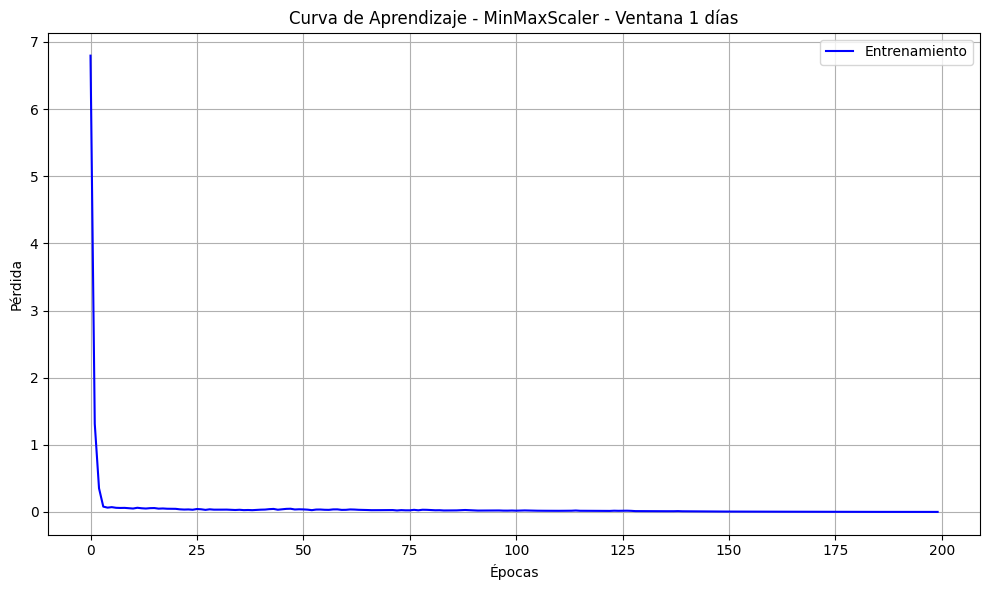

In [12]:
        # 5. Curva de Aprendizaje
        plt.figure(figsize=(10, 6))
        plt.plot(history['loss'], label='Entrenamiento', color='blue')
        if 'val_loss' in history:
            plt.plot(history['val_loss'], label='Validación', color='orange')
        plt.title(f'Curva de Aprendizaje - {scaler_name} - Ventana {window_days} días')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()

In [13]:
# Define las columnas de entrada y salida
input_features = ['Irradiancia', 'NO3', 'TEMP', 'pH','CO2 Gas']  # RHeemplaza con los nombres reales de tus características
output_feature = 'Biomasa'  # Cambia al nombre real de tu variable dependiente en el DataFrame
				


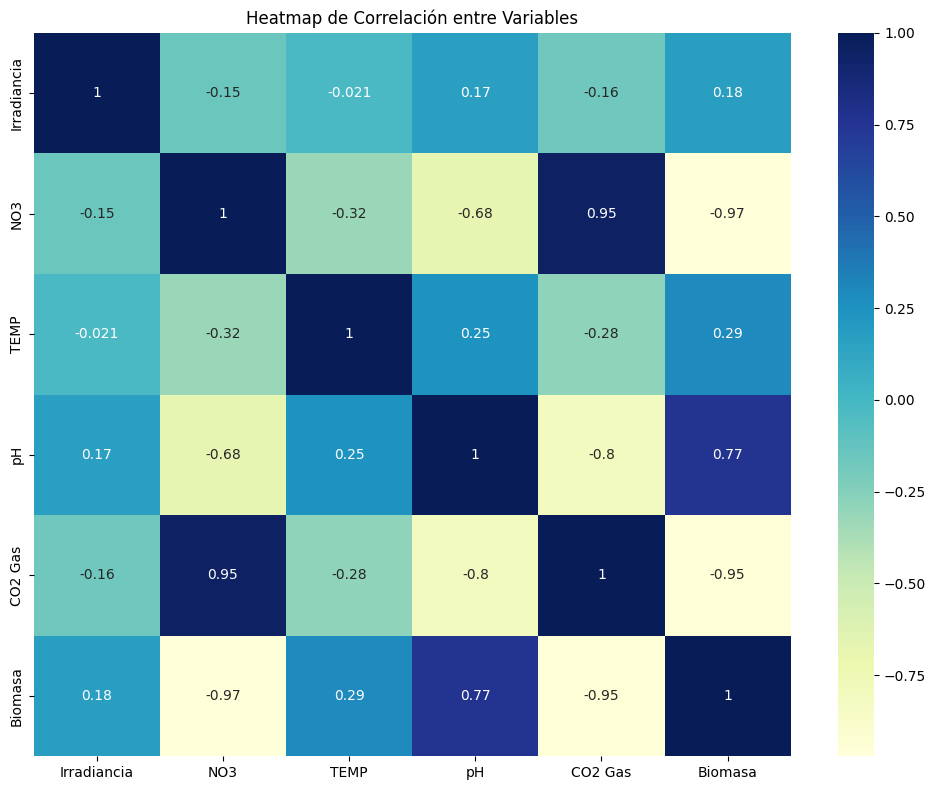

In [14]:
# Bloque 7: Heatmap de Correlación
plt.figure(figsize=(10, 8))

# Verifica que las columnas existen en el DataFrame
features_to_correlate = input_features + [output_feature]
assert all(feature in data.columns for feature in features_to_correlate), \
    "Algunas columnas no están presentes en el DataFrame."

sns.heatmap(data[features_to_correlate].corr(), annot=True, cmap="YlGnBu")
plt.title("Heatmap de Correlación entre Variables")
plt.tight_layout()
plt.show()
